# Opinoin strength extension 

The opinion strength extension model is described in SM Section 5.4 of the paper. 

The transition rates of individual learners are changed to be: $P(Y\rightarrow X) = wm$, $P(X \rightarrow Y) = (1-w)(1-m)$. Here  $w$ is the "strength" or "stubborness" of opinoin $X$ relative to $Y$. 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.optimize import root
import matplotlib.lines as mlines
import copy

# import functions in my_functions
import ipynb.fs.defs.my_functions as myfun

### ODE system

In [2]:
def odeSys(var, t, para):
    x_i,x_s = var # proportion of individual and social learners holding x
    s = para["s"]
    m = para["m"]
    alpha = para["alpha"]
    w_x = para["w_x"]
    
    x = (1-s)*x_i + s*x_s
    
    
    # transition rates of individual learner
    p_yx_i = w_x*m 
    p_xy_i = (1 - w_x)*(1-m)
    
    dx_idt = p_yx_i*(1-x_i) - p_xy_i*x_i
    
    # transition rates for people of x opinion in social learners
    p_yx_s = myfun.f(x, alpha)
    p_xy_s = myfun.f((1-x), alpha)
    
    dx_sdt = p_yx_s*(1-x_s) - p_xy_s*x_s
    
    return [dx_idt, dx_sdt]

### Run ODE system over time

Text(0.5, 0, 'time')

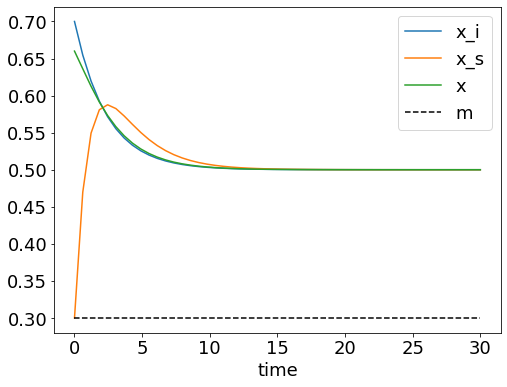

In [3]:
# run ode
var0 = [0.7, 0.3] # x_i, x_s
para = {"s": 0.1, "m": 0.3, "alpha": 1.2, "w_x": 0.7}
t = np.linspace(0, 30, 50) #  time 

var = odeint(odeSys, var0, t, args = (para,))

# plot results 
x_i = var[:,0]
x_s = var[:, 1]
x = (1-para["s"])*x_i + para["s"]*x_s

plt.figure(figsize = (8, 6))
plt.plot(t, x_i) 
plt.plot(t, x_s)
plt.plot(t, x )
plt.plot(t, para["m"]*np.ones(np.shape(t)), "k--")
plt.legend(["x_i", "x_s", "x", "m"])
plt.xlabel("time")


## Run ODE system till convergence

In [4]:
def ode_til_converge(para, var0, seg_l = 30, seg_n = 100, nseg = 5000, tol = 1e-6, window = 30):
    """
    Integrate the ode by segements, and check convergence after each segment, until convergence critiria is met. 
    seg_l: length of time segment 
    seg_n: number of time steps in segment
    nseg: number of max segment
    """
    
    tmin = 0
    var = var0
    conv_flag = 0 # flag for checking convergence
    
    for i in range(nseg): 
        t = np.linspace(tmin, tmin + seg_l, seg_n)
        var = odeint(odeSys, var0, t, args = (para,))
        
        tmin = tmin+ seg_l
        
        # check convergence
        x_i = var[:,0]
        x_s = var[:, 1]
        x = (1 - para["s"])*x_i + para["s"]*x_s
        
        converge, avg, std = myfun.checkConverge(x, tol , window )
        
        if converge == 1:
            conv_flag = 1
            break
            
        # update initial condition 
        var0 = [x_i[-1], x_s[-1]]
   
    out = {"t_cov": tmin, "x_ss": x[-1], "x_i": x_i[-1], "x_s":x_s[-1], "conv_flag": conv_flag }    

    return out  


## For fixed w, sweep s

In [5]:
def run_multi_r(sList, var0List, para):
    """
    Run the ode til convergence for multiple s's and multiple IC's. 
    """
    xLists = []
    for var0 in var0List: 
        xList = []
        for s in sList: 
            para["s"] = s
            out =  ode_til_converge(para, var0)
            if out["conv_flag"] == 0:
                print("warning: simulation didn't converge. ")
            xList.append(out["x_ss"])
        xLists.append(xList)
    return xLists 

m = 0.6
sList = np.linspace(0., 0.99, 60)
var0List =[[0.9, 0.9], [0.05, 0.05]] # x_i, x_s
para3 = {"s": np.nan, "m": m, "alpha": 1.5, "w_x": 0.5}

xLists3 = run_multi_r(sList, var0List, para3)



In [6]:
# run the case where minirity opinion is held at unequal strength 

rList = np.linspace(0,1, 100)
para4 = {"r": np.nan, "m": m, "alpha": 1.5,"w_x": 0.3}
xLists4 = run_multi_r(sList, var0List, para4)

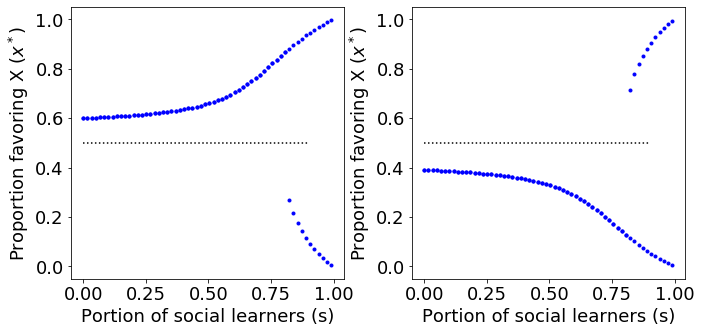

In [7]:
plt.figure(figsize = (11, 5))
plt.subplot(1, 2, 1)
for i, var0 in enumerate(var0List): 
    plt.plot(sList, xLists3[i], "b.")

plt.xlabel("Portion of social learners (s)")
plt.ylabel("Proportion favoring X ($x^*$)")
plt.plot([0.0, 0.9], [0.5, 0.5], "k:")
plt.ylim([-0.05, 1.05])  

plt.subplot(1, 2, 2)
for i, var0 in enumerate(var0List): 
    plt.plot(sList, xLists4[i], "b.")

plt.xlabel("Portion of social learners (s)")
plt.ylabel("Proportion favoring X ($x^*$)")
plt.plot([0.0, 0.9], [0.5, 0.5], "k:")
plt.ylim([-0.05, 1.05])  
plt.subplots_adjust(wspace = 0.25)

plt.savefig('fig3.pdf', dpi = 700)

